https://nextjournal.com/gkoehler/pytorch-mnist

In [1]:
import torch
import torchvision

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.RandomRotation(degrees=(-90,90),fill=(0,)),
                              torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.RandomRotation(degrees=(-90,90),fill=(0,)),
                              torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

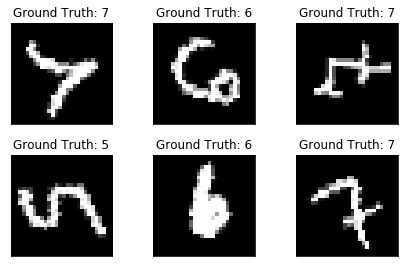

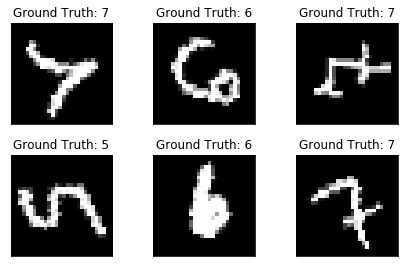

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3027, Accuracy: 941/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.254925
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.271292
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281166
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.302848
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.307589
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.313308
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.284825
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.273225
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.257732
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.220815
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.233693
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.222205
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.190961
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.229445
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.205474
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.138900
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.101924
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.161112
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.091830
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.772074
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.064180
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.835613
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.955627
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.163356
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.780474
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.901215
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.060246
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.983803
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.959214
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.026972
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.263508
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.826819
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.986549
Train Epoch: 2 [53120/60000 (88%)]	Loss: 1.073839
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.725612
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.891953
Train Epoch: 2 [55040/60000 (92%)]	Loss: 1.068698
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.960232
Train Epoch: 2 [56320/60000 (94%)]	Loss: 1.015484


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.727164
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.852713
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.855669
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.670316
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.631787
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.873483
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.786927
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.484908
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.665807
Train Epoch: 4 [33920/60000 (57%)]	Loss: 1.072682
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.472812
Train Epoch: 4 [35200/60000 (59%)]	Loss: 1.076268
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.897563
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.832537
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.806945
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.690373
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.525125
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.714388
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.661795
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.828277


Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.600457
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.655363
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.703504
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.635229
Train Epoch: 6 [14720/60000 (25%)]	Loss: 1.007318
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.494315
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.907042
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.735595
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.583591
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.443893
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.501464
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.650268
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.455055
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.496411
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.745853
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.866504
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.491218
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.945824
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.386430
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.563902


Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.649316
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.468539
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.415113
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.748974
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.539609

Test set: Avg. loss: 0.2520, Accuracy: 9239/10000 (92%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.708368
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.616111
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.580028
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.546483
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.458650
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.468660
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.539593
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.430509
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.657769
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.452387
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.541242
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.639058
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.635912
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.771971
Train Epoch: 8 [896

Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.564414
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.659867
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.606825
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.698287
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.546440
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.671864
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.611977
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.565315
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.645161
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.746867
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.694478
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.475839
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.702729
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.551511
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.477549
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.450852
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.436082
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.542005
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.521713
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.943859


In [14]:
with torch.no_grad():
  output = network(example_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


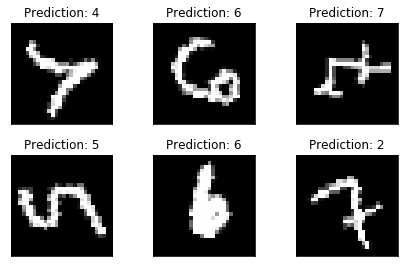

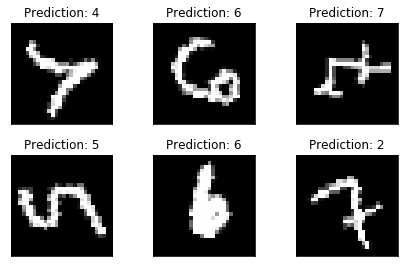

In [15]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig